In [24]:
import torch
from d2l import torch as d2l
import time
import matplotlib.pyplot as plt

In [25]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [26]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

In [22]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return softmax(torch.matmul(X, self.W) + self.b)
    
    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)
    
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.plot_flag:
            self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        if self.plot_flag:
            self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
            self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        return l

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. As discussed in Section 4.1 this can cause numerical instabilities.
    1. Test whether `softmax` still works correctly if an input has a value of $100$.
    2. Test whether `softmax` still works correctly if the largest of all inputs is smaller than $-100$.
    3. Implement a fix by looking at the value relative to the largest entry in the argument.

(1) If an input has a value of 100:

In [3]:
X = torch.randn((1,5))
X[0][0] = 100

print(softmax(X))

tensor([[nan, 0., 0., 0., 0.]])

Exponentiating such large values can result in overflow issues, causing incorrect or undefined results.

(2)If the largest of all inputs is smaller than -100:

In [4]:
X = torch.randn((1,5))
X -= 120

print(softmax(X))

tensor([[nan, nan, nan, nan, nan]])


Exponentiating small values will result in zero ouput. The denominator is 0, which can result in underflow issues.

(3) Implement a fix: softmax(X) = softmax(X + b)

In [5]:
def softmax_fix(X):
    X_max = X.max()
    X -= X_max
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition

X = torch.randn((1,5))
X[0][0] = 100
print(softmax_fix(X))

X = torch.randn((1,5))
X -= 120
print(softmax_fix(X))

tensor([[1.0000e+00, 7.4269e-44, 3.5032e-44, 9.8091e-45, 3.7835e-44]])
tensor([[0.1292, 0.1095, 0.1904, 0.2959, 0.2750]])


2. Implement a `cross_entropy` function that follows the definition of the cross-entropy loss function $\sum_i y_i \log \hat{y}_i$.
    1. Try it out in the code example of this section.
    2. Why do you think it runs more slowly?
    3. Should you use it? When would it make sense to?
    4. What do you need to be careful of? Hint: consider the domain of the logarithm.

In [16]:
def cross_entropy_new(y_hat, y):
    y_onehot = torch.zeros_like(y_hat)
    y_onehot[list(range(len(y_hat))), y] = 1
    return -(y_onehot * torch.log(y_hat)).sum() / y_hat.shape[0]

y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
cross_entropy_new(y_hat, y)

tensor(1.4979)

(1) We first run the origin version:

115.25 sec


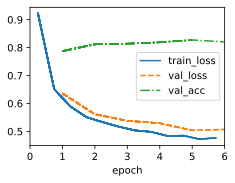

In [11]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=6)
time1 = time.time()
trainer.fit(model, data)
print(f'{(time.time() - time1):.2f} sec')

137.88 sec


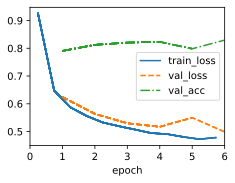

In [18]:
class SoftmaxRegressionScratch2(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return softmax(torch.matmul(X, self.W) + self.b)
    
    def loss(self, y_hat, y):
        return cross_entropy_new(y_hat, y)

data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch2(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=6)
time1 = time.time()
trainer.fit(model, data)
print(f'{(time.time() - time1):.2f} sec')

(2) It runs more slowly because: 
- the label y need to change to the one hot vector
- it involves performing element-wise multiplication
  
(3) I think we don't need to use it.

(4) The logarithm is undefined for zero or negative values. To prevent this, we can add a small constant value to them before taking the logarithm.

3. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?

https://pandalab.me/archives/softmax_regression_implementation_from_scratch

4. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?

https://pandalab.me/archives/softmax_regression_implementation_from_scratch

Computational Complexity, sparse gradient, data Sparsity ...

5. Experiment with the hyperparameters of the code in this section. In particular:
    1. Plot how the validation loss changes as you change the learning rate.
    2. Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?

In [27]:
@d2l.add_to_class(d2l.Trainer) #@save
def return_train_loss(self):
    loss = 0
    for batch in self.train_dataloader:
        loss += self.model.training_step(self.prepare_batch(batch)).item()
    loss /= len(self.train_dataloader)
    return loss

@d2l.add_to_class(d2l.Trainer) #@save
def return_val_loss(self):
    loss = 0
    for batch in self.val_dataloader:
        loss += self.model.validation_step(self.prepare_batch(batch)).item()
    loss /= len(self.val_dataloader)
    return loss

(1) $lr = [0.001, 0.01, 0.1, 1]$

lr=0.001, val_loss=1.02
lr=0.01, val_loss=0.62
lr=0.1, val_loss=0.48
lr=1, val_loss=nan


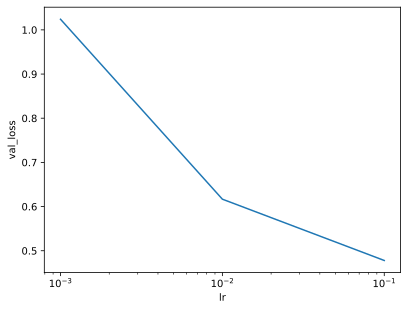

In [32]:
data = d2l.FashionMNIST(batch_size=256)
lrs = [0.001,0.01,0.1,1]
valid_loss = []
for lr in lrs:
    model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=lr, plot_flag=False)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    l = trainer.return_val_loss()
    print(f'lr={lr}, val_loss={l:.2f}')
    valid_loss.append(l)

plt.plot(lrs, valid_loss)
plt.xscale('log')
plt.xlabel("lr")
plt.ylabel("val_loss")
plt.show()

(2) $batch = [1, 8, 64, 256, 512, 1024]$

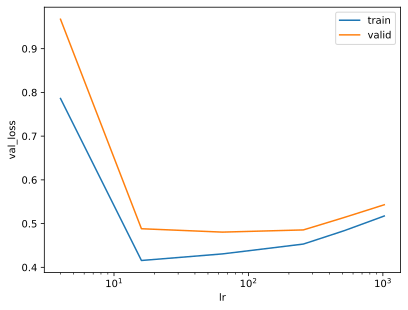

In [36]:
batches = [1, 4, 16, 64, 256, 512, 1024]
train_loss, valid_loss = [],[]
for batch in batches:
    data = d2l.FashionMNIST(batch_size=batch)
    model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1, plot_flag=False)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    train_loss.append(trainer.return_train_loss())
    valid_loss.append(trainer.return_val_loss())

plt.plot(batches, train_loss, label="train")
plt.plot(batches, valid_loss, label="valid")
plt.xscale('log')
plt.xlabel("lr")
plt.ylabel("val_loss")
plt.legend()
plt.show()